# Demo 1: EWS in the Ricker model

The objectives of this demo are as follows:
- Simulate a single stochastic trajectory of the Ricker model going through a Fold bifurcation
- Show how to use the package *ewstools* to compute early warning signals
- Visualise the output of *ewstools* graphically
- Run time < 1 min


## Import the standard Python libraries and ewstools

In [26]:
# We will require the following standard Python packages for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

# This is the package we use to compute the early warning signals
import ewstools

## Simulate the Ricker model

Here we simulate a single trajectory of the Ricker model going through a Fold bifurcation. We will use this data to demonstrate the process of computing EWS. Alternatively, you could import your own data here. The importnat thing is that we end up with a Pandas DataFrame indexed by time.

**Set simulation parameters**

In [27]:
dt = 1 # time-step (using 1 since discrete-time system)
t0 = 0 # starting time
tmax = 500 # end time
tburn = 100 # burn-in period preceding start-time
seed = 1 # random number generation seed (set for reproducibility)
np.random.seed(seed)

**Define model**

We use the Ricker model with a Holling Type II harvesting term and additive white noise. It is given by
$$ N_{t+1} = N_t e^{(r(1-N_t/K) + \sigma\epsilon_t} ) - F\frac{N_t^2}{N_t^2 + h^2}$$
where $N_t$ is the population size at time $t$, $r$ is the intrinsic growth rate, $K$ is the carrying capacity, $F$ is the maximum rate of harvesting, $h$ is the half saturation constant of the harvesting term, $\sigma$ is the noise amplitude, and $\epsilon_t$ is a normal random variable with zero mean and unit variance.

In [28]:
# Define the model
def de_fun(x,r,k,f,h,xi):
    return x*np.exp(r*(1-x/k)+xi) - f*x**2/(x**2+h**2)

**Set model parmaeters**

In [29]:
r = 0.75 # growth rate
k = 10 # carrying capacity
h = 0.75 # half-saturation constant of harvesting function
bl = 0 # bifurcation parameter (harvesting) low
bh = 2.7 # bifurcation parameter (harvesting) high
bcrit = 2.364 # bifurcation point (computed using XPPAUT)
sigma = 0.02 # noise intensity
x0 = 0.8 # initial condition

**Initialisation**

In [30]:
# Initialise arrays for time and state values
t = np.arange(t0,tmax,dt)
x = np.zeros(len(t))

# Bifurcation parameter values (increasing linearly in time)
b = pd.Series(np.linspace(bl,bh,len(t)),index=t) # bifurcation parameter values over time (linear increase)

# Compute time at which bifurcation is crossed
tcrit = b[b > bcrit].index[1]

# Array of noise values (normal random variables with variance sigma^2 dt)
dW_burn = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = int(tburn/dt)) # burn-in period
dW = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = len(t)) # monitored period

**Run simulation**

In [36]:
# Run burn-in period starting from intiial condition x0
for i in range(int(tburn/dt)):
    x0 = de_fun(x0,r,k,bl,h,dW_burn[i])

# State value post burn-in period. Set as starting value.
x[0]=x0

# Run simulation using recursion
for i in range(len(t)-1):
    x[i+1] = de_fun(x[i],r,k,b.iloc[i], h,dW[i])
    # Make sure that state variable stays >= 0
    if x[i+1] < 0:
        x[i+1] = 0
        
# Store array data in a DataFrame indexed by time
sim_data = {'Time': t, 'x': x}
df_traj = pd.DataFrame(sim_data)
df_traj.set_index('Time', inplace=True)

We now have a DataFrame df_traj, with our trajectory, indexed by time. We can check it out with a simple plot, using the command

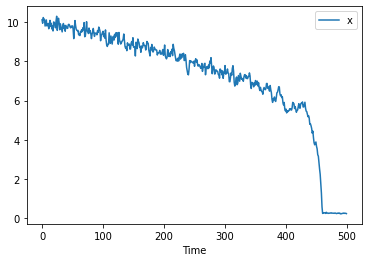

In [37]:
df_traj.plot();

## Compute EWS

We can now use *ewstools* to compute early warning signals that precede this bifurcation. The package can compute the following statistical metrics. Simply put the label into the argument ews.

| EWS  | Label | Notes |
| ------------- | ------------- | -------------- |
| Variance  | 'var'  | Second moment of the data. Increases with critical slowing down. |
| Standard deviation | 'sd'  | Root of the variance. Increases with critical slowing down. |
| Coefficient of variation | 'cv'  | Ratio of standard deviation to the mean. Useful when mean of system varies over time. |
| Skewness | 'skew'  | Third standardised moment of the data. Increases preceding Fold bifurcations. |
| Kurtosis | 'kurt'  | Fourth standardised moment of the data |
| Autocorrelation | 'ac'  | Correlation between data-points a given lag-time apart. Increases with critical slowing down for sufficiently small lags.|
| Smax | 'smax'  | Peak in the power spectrum. Increases with critical slowing down. |
| Coherence factor | 'cf'  | Ratio of height to width of peak in the power spectrum. Increases preceding a Hopf bifurcation. |
| AIC weights | 'aic'  | Weights characterising the class of bifurcation |



**Set EWS parameters**

First we must configure some imporant parameters that are used in the process of finding early warning signals. For more details on the description of these parameters, check out the *ewstools* documentation. 

Sensible choices of these parameters will depend on the resolution and scale of your data. Details on how to select these parameter values can be found in the mothodological paper by [Dakos et al.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041010)

In [47]:
tcrit

438

In [48]:
rw = 0.5*(438/500) # rolling window
span = 0.2 # Lowess span
lags = [1,2,3] # autocorrelation lag times to compute
ews = ['var','sd','cv','skew','kurt','ac','smax','cf','aic'] # EWS to compute (let's do all of them)
ham_length = 80 # number of data points in Hamming window
ham_offset = 0.5 # proportion of Hamming window to offset by upon each iteration
pspec_roll_offset = 20 # offset for rolling window when doing spectrum metrics

**Run ews_compute**

ews_compute is the main function in the package *ewstools*. It takes in your time-series data, along with your parameter configurations, and outputs the specified EWS.

In [49]:
ews_dic = ewstools.core.ews_compute(df_traj['x'],
                                   smooth='Lowess',
                                   roll_window = rw, 
                                   span = span,
                                   lag_times = lags, 
                                   ews = ews,
                                   upto=tcrit)

**Extract info**

ews_compute outputs a dictionary containing three DataFrames
- *EWS metrics* : column for each EWS indexed by time
- *Power spectrum* : measured power spectrum and fitted power spectra indexed by time and frequency
- *Kendall tau* : Kendall tau values for each EWS

In [50]:
# The DataFrame of EWS
df_ews = ews_dic['EWS metrics']
# The DataFrame of power spectra
df_pspec = ews_dic['Power spectrum']
# The DataFrame of ktau values
df_ktau = ews_dic['Kendall tau']

Here is a sample from the EWS DataFrame

In [51]:
df_ews.dropna().head(3)

,State variable,Smoothing,Residuals,Standard deviation,Variance,Lag-1 AC,Lag-2 AC,Lag-3 AC,Coefficient of variation,Skewness,Kurtosis,Smax,Coherence factor,AIC fold,AIC hopf,AIC null,Params fold,Params flip,Params hopf,Params null
Time,,,,,,,,,,,,,,,,,,,,
218,8.353670,8.261051,0.092619,0.198904,0.039563,0.239890,0.049045,-0.003118,0.021627,-0.005122,0.177231,0.002896,0.001448,1.0,1.206526e-10,7.754067e-11,"{'sigma': 0.23729683193032602, 'lam': -1.96802...","{'sigma': 0.09576836641914256, 'r': -1.9053869...","{'sigma': 0.614797245738754, 'mu': -5.75089849...",{'sigma': 0.09576783726059354}
238,7.524332,8.050742,-0.526410,0.202988,0.041204,0.272654,0.045116,-0.011939,0.022471,-0.058786,0.173945,0.002856,0.001428,1.0,1.305635e-11,9.902635e-12,"{'sigma': 0.2205917201804984, 'lam': -1.815424...","{'sigma': 0.0942206433657914, 'r': -1.10367048...","{'sigma': 0.6049032674465442, 'mu': -5.7472498...",{'sigma': 0.09421993053039378}
258,7.801663,7.827556,-0.025893,0.209522,0.043900,0.382865,0.165886,0.024308,0.023666,-0.362893,0.909053,0.002994,0.000000,1.0,2.307153e-13,2.559770e-13,"{'sigma': 0.1998910763012033, 'lam': -1.492447...","{'sigma': 0.09811985223229108, 'r': -7.3163697...","{'sigma': 0.6349764570168284, 'mu': -5.7976249...",{'sigma': 0.09811919736773222}


Note that the spectral metrics are computed at a lower time-resolution, and so have many blank cells (Nan). The DataFrame of Kendall tau values for each EWS looks like

In [52]:
df_ktau

,Lag-1 AC,Coefficient of variation,Lag-2 AC,Kurtosis,Skewness,Standard deviation,Lag-3 AC,Smax,Variance
0,0.896833,0.932127,0.738955,-0.08696,0.240724,0.486302,0.425998,0.818182,0.486302


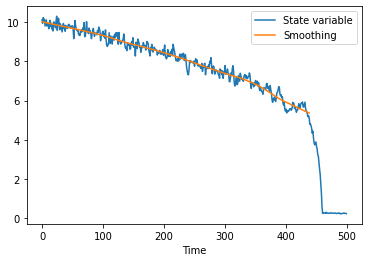

In [53]:
df_ews[['State variable','Smoothing']].plot();

## Visualise EWS

We can visualise the EWS by constructing some plots using the Seaborn package.

**Early warning signals**

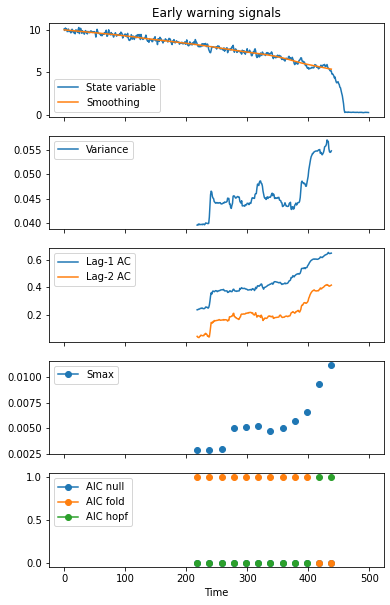

In [54]:
## Plot of trajectory, smoothing and EWS of var (x or y)
fig1, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,10), sharex=True)
df_ews[['State variable','Smoothing']].plot(ax=axes[0],
          title='Early warning signals')
df_ews['Variance'].plot(ax=axes[1],legend=True)
df_ews[['Lag-1 AC','Lag-2 AC']].plot(ax=axes[2],legend=True)
df_ews['Smax'].plot(ax=axes[3],legend=True, marker='o')
df_ews[['AIC null','AIC fold','AIC hopf']].plot(ax=axes[4],legend=True, marker='o');

**Power spectra**

A grid plot to visualise the evolution of the power spectrum

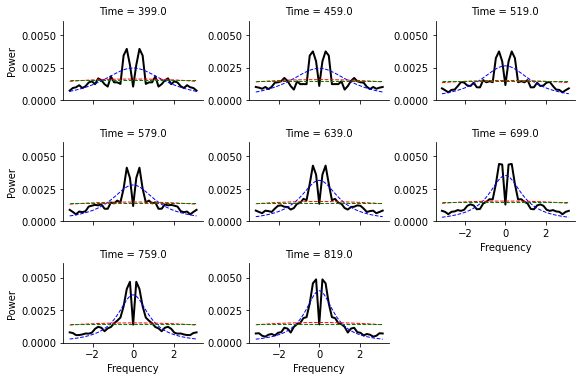

In [14]:
def plot_pspec_grid(tVals):
    '''
    Plot a grid of power spectra, their fits, and AIC values at different times leading up to the bifurcation
    
    Args
    --------
    tVals: An array of time values at which to plot the power spectrum
    
    Returns
    ----------
    A grid plot
    
    '''
    g = sns.FacetGrid(df_pspec.loc[t_display].reset_index(), 
                  col='Time',
                  col_wrap=3,
                  sharey=False,
                  aspect=1.5,
                  height=1.8
                  )

    g.map(plt.plot, 'Frequency', 'Empirical', color='k', linewidth=2)
    g.map(plt.plot, 'Frequency', 'Fit fold', color='b', linestyle='dashed', linewidth=1)
    g.map(plt.plot, 'Frequency', 'Fit hopf', color='r', linestyle='dashed', linewidth=1)
    g.map(plt.plot, 'Frequency', 'Fit null', color='g', linestyle='dashed', linewidth=1)
    # Axes properties
    axes = g.axes
    # Set y labels
    for ax in axes[::3]:
        ax.set_ylabel('Power')
        # Set y limit as max power over all time
        for ax in axes:
            ax.set_ylim(top=1.05*max(df_pspec['Empirical']), bottom=0)
#            ax.set_yscale('log')
       
    return g

#  Choose time values at which to display power spectrum
t_display = df_pspec.index.levels[0][::3].values

plot_pspec = plot_pspec_grid(t_display)

Notice how the power spectrum conforms most closely to that of the Fold bifurcation, thus $w_{\text{Fold}}$ is the AIC weight. We also see the rise in the peak of the power spectrum as the bifurcation is approached.